In [1]:
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
import itertools
import scipy.stats as st
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
import rpy2
import pingouin as pg

/Users/zeleninam2/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [13]:
# ICC - https://www.uvm.edu/~statdhtx/methods8/Supplements/icc/More%20on%20ICCs.pdf
# ICC(2,1) - Each subject is measured by each rater, and raters are considered representative
#            of a larger population of similar raters. 
#            Reliability calculated from a single measurement.

In [14]:
# I found two python implementations:
#     1 - pinguoin 
#     https://pingouin-stats.org/build/html/generated/pingouin.intraclass_corr.html
#     2 - rpy2
#     https://www.r-bloggers.com/2021/06/intraclass-correlation-coefficient-in-r-quick-guide/
#     also:
#     https://stackoverflow.com/questions/40965579/intraclass-correlation-in-python-module

In [15]:
# ICC(2,1) for : 
# total score of HITOP
# total score of BAARS
# each subscale of HITOP
# each subscale of BAARS-IV
# GAD-7
# PHQ-8

In [2]:
# general
#data_path = 'data/mydata_1_forICC.csv'
#path_to_save = 'results/ICC_general.csv'

#highrisk
data_path = 'data/mydata_1highrisk_forICC.csv'
path_to_save = 'results/ICC_highrisk.csv'


mydata = pd.read_csv(data_path)
mydata = mydata.rename(columns={'Unnamed: 0': 'Subject'})
mydata.head()

,Subject,hitop_sum,hitop_sum_recontact,baars_sum,baars_sum_recontact,phq_sum,phq_sum_recontact,gad_sum,gad_sum_recontact,mood_bothered,mood_bothered_recontact,anxiety_bothered,anxiety_bothered_recontact,attention_bothered,attention_bothered_recontact,moodanxiety_bothered,moodanxiety_bothered_recontact,baars_inattention_sum,baars_inattention_sum_recontact,baars_hyperactivity_sum,baars_hyperactivity_sum_recontact,baars_impulsivity_sum,baars_impulsivity_sum_recontact,baars_sct_sum,baars_sct_sum_recontact,hitop_anhedonic_depression,hitop_anhedonic_depression_recontact,hitop_anxious_worry,hitop_anxious_worry_recontact,hitop_appetite_gain,hitop_appetite_gain_recontact,hitop_appetite_loss,hitop_appetite_loss_recontact,hitop_cognitive_problems,hitop_cognitive_problems_recontact,hitop_hyposomnia,hitop_hyposomnia_recontact,hitop_indecisiveness,hitop_indecisiveness_recontact,hitop_insomnia,hitop_insomnia_recontact,hitop_panic,hitop_panic_recontact,hitop_separation_insecurity,hitop_separation_insecurity_recontact,hitop_shame_guilt,hitop_shame_guilt_recontact,hitop_situational_phobia,hitop_situational_phobia_recontact,hitop_social_anxiety,hitop_social_anxiety_recontact,hitop_well_being,hitop_well_being_recontact
0,0,80,115,13,19,14,17,7,16,True,True,False,True,False,False,True,True,6,13,6,6,1,0,7,10,11,22,6,14,9,9,0,0,1,6,0,0,0,0,12,12,3,5,10,13,9,10,7,9,12,15,11,10
1,2,123,133,41,43,15,14,14,18,True,True,True,True,True,True,True,True,21,22,11,13,9,8,25,21,16,16,17,19,2,0,2,2,12,12,9,6,9,9,5,7,8,10,12,14,10,11,2,4,19,23,8,7
2,3,84,84,0,12,12,9,16,10,False,True,False,True,False,False,False,True,0,2,0,2,0,8,12,7,12,14,10,9,3,3,2,2,4,3,0,0,4,3,12,12,12,8,4,9,9,4,0,3,12,14,14,15
3,5,156,129,15,16,21,21,21,15,True,True,True,True,True,True,True,True,12,15,3,1,0,0,20,17,27,17,20,18,2,0,6,4,10,9,0,0,9,8,12,11,12,10,20,17,11,12,1,1,26,22,6,5
4,8,96,91,8,6,7,6,15,14,False,False,True,True,False,False,True,True,5,4,1,1,2,1,11,8,8,11,18,16,2,2,0,0,5,5,0,0,5,3,3,4,5,5,15,13,6,4,1,0,28,28,18,21


In [110]:
def do_icc(data, measure, show = True):
    # just the measure of interest
    data_measure = data[['Subject', measure, measure+'_recontact']]
    data_measure = data_measure.rename(columns={measure: "Original", measure+'_recontact': "Recontact"})
    data_measure_melted = pd.melt(data_measure, id_vars='Subject', value_vars=['Original','Recontact'], value_name='Score')
    data_measure_melted = data_measure_melted.rename(columns={"variable": "Session"})
    # adding Measure - don't really need to do it but eh
    shape = data_measure_melted.shape
    data_measure_melted['Measure'] = [measure] * shape[0]
    print(measure)
    icc = pg.intraclass_corr(data=data_measure_melted, targets='Subject', raters='Session', ratings='Score').round(3)
    icc.set_index("Type")
    #print(icc)
    if show:
        plt = sns.jointplot(data=data_measure, x='Original', y='Recontact')
        plt.fig.suptitle(measure)
        #plt = plt.set(title=measure)
        #plt.subtitle(measure)
        #plt.show()
        print(icc)
    return (icc)

In [111]:
def create_table (data, measures):
    df_init = pd.DataFrame()
    for measure in measures:
        if 'bothered' not in measure:
            print(measure)
            new_icc = do_icc(data, measure, show=False)
            new_icc_row = new_icc.iloc[['1']]
            new_icc_row['Measure'] = measure
            df_init = pd.concat([df_init, new_icc_row], axis = 0)
    df_result = df_init
    return (df_result)

hitop_sum
    Type              Description    ICC       F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.823  10.323  256  257   0.0  [0.78, 0.86]
1   ICC2     Single random raters  0.823  10.313  256  256   0.0  [0.78, 0.86]
2   ICC3      Single fixed raters  0.823  10.313  256  256   0.0  [0.78, 0.86]
3  ICC1k  Average raters absolute  0.903  10.323  256  257   0.0  [0.88, 0.92]
4  ICC2k    Average random raters  0.903  10.313  256  256   0.0  [0.88, 0.92]
5  ICC3k     Average fixed raters  0.903  10.313  256  256   0.0  [0.88, 0.92]
baars_sum
    Type              Description    ICC      F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.804  9.181  256  257   0.0  [0.76, 0.84]
1   ICC2     Single random raters  0.803  9.156  256  256   0.0  [0.76, 0.84]
2   ICC3      Single fixed raters  0.803  9.156  256  256   0.0  [0.75, 0.84]
3  ICC1k  Average raters absolute  0.891  9.181  256  257   0.0  [0.86, 0.91]
4  ICC2k    Average random raters  0.

/Users/zeleninam2/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:1696: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(height, height))


    Type              Description    ICC      F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.817  9.948  256  257   0.0  [0.77, 0.85]
1   ICC2     Single random raters  0.817  9.925  256  256   0.0  [0.77, 0.85]
2   ICC3      Single fixed raters  0.817  9.925  256  256   0.0  [0.77, 0.85]
3  ICC1k  Average raters absolute  0.899  9.948  256  257   0.0  [0.87, 0.92]
4  ICC2k    Average random raters  0.899  9.925  256  256   0.0  [0.87, 0.92]
5  ICC3k     Average fixed raters  0.899  9.925  256  256   0.0  [0.87, 0.92]
hitop_well_being
    Type              Description    ICC      F  df1  df2  pval         CI95%
0   ICC1   Single raters absolute  0.785  8.316  256  257   0.0  [0.73, 0.83]
1   ICC2     Single random raters  0.785  8.286  256  256   0.0  [0.73, 0.83]
2   ICC3      Single fixed raters  0.785  8.286  256  256   0.0  [0.73, 0.83]
3  ICC1k  Average raters absolute  0.880  8.316  256  257   0.0  [0.85, 0.91]
4  ICC2k    Average random raters  0.880  8.286

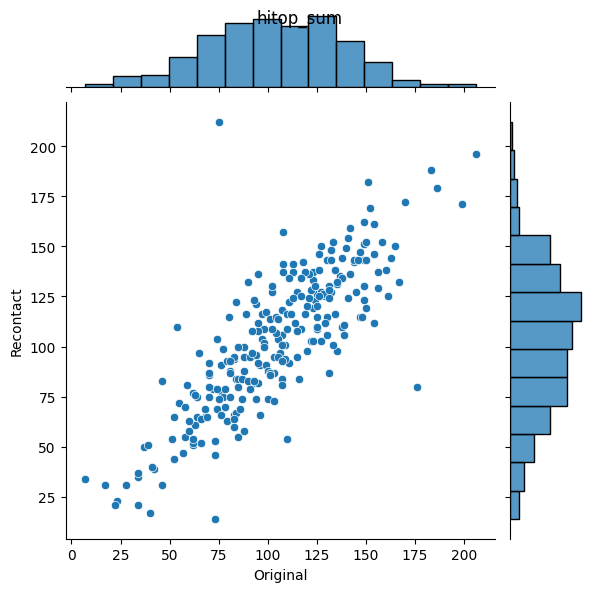

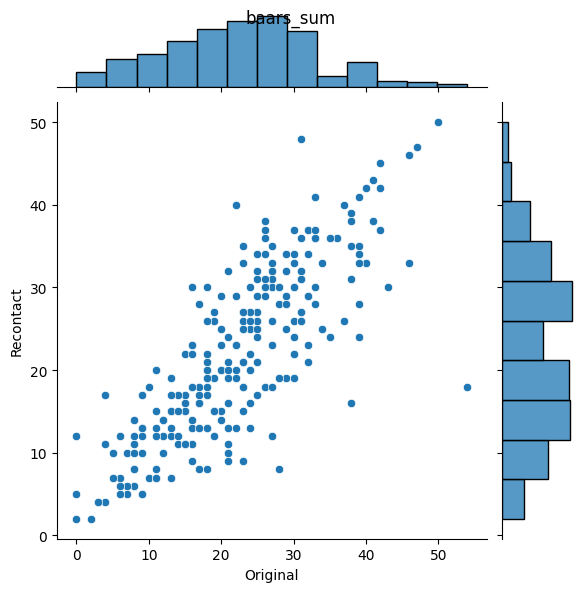

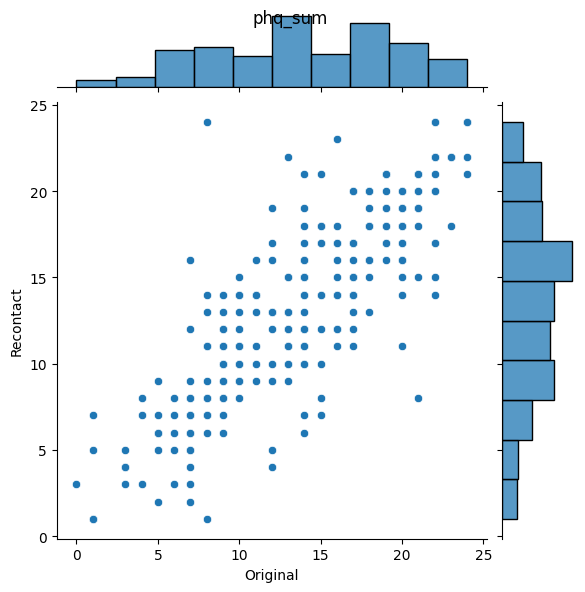

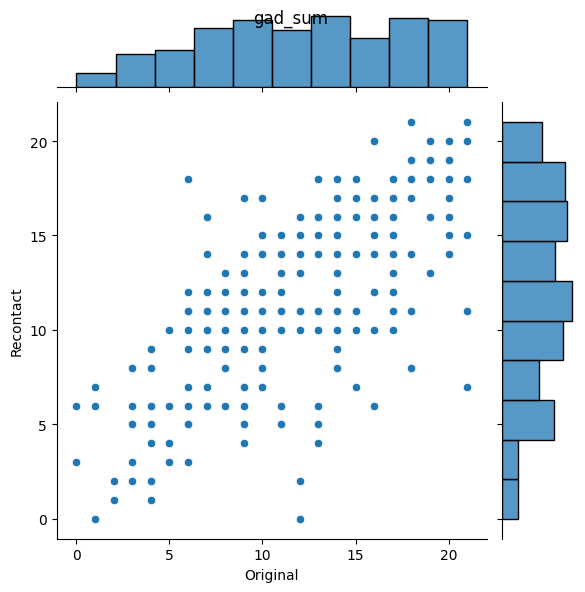

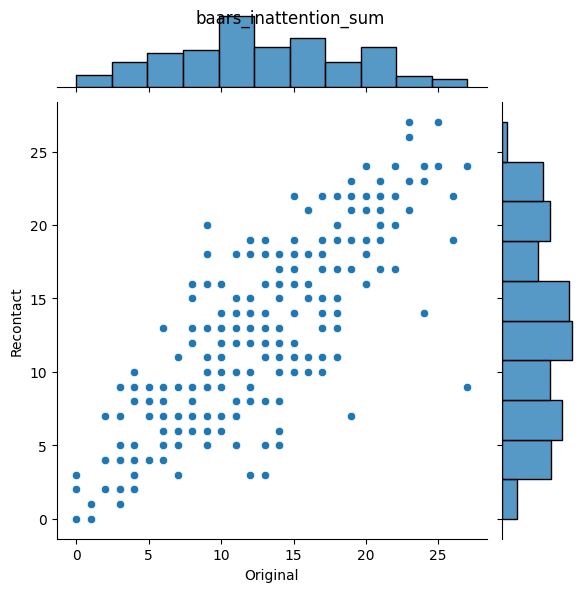

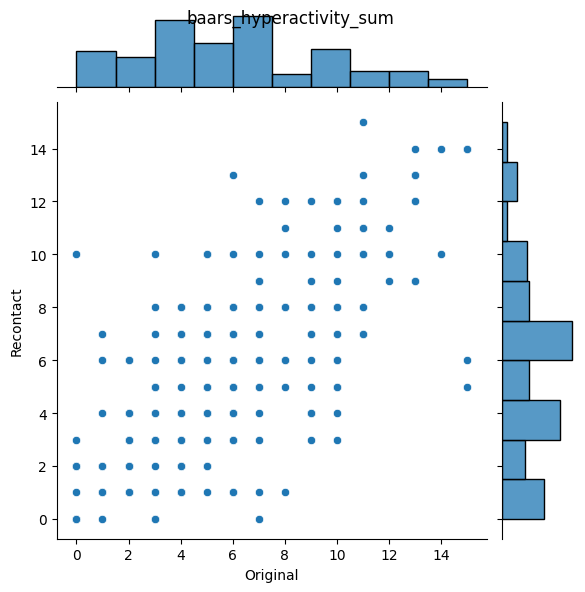

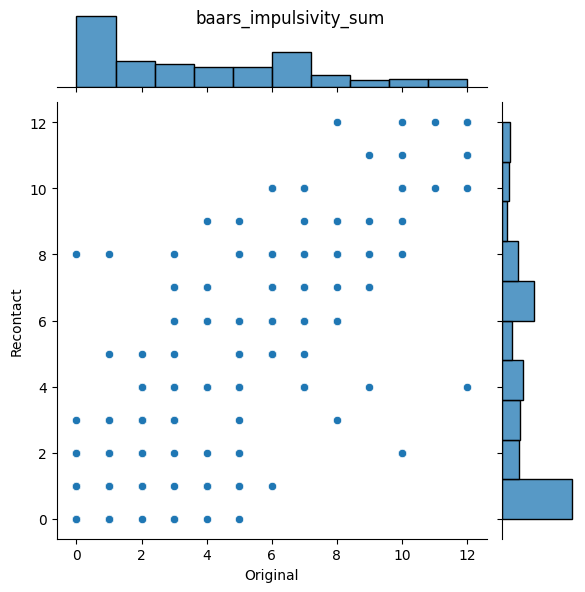

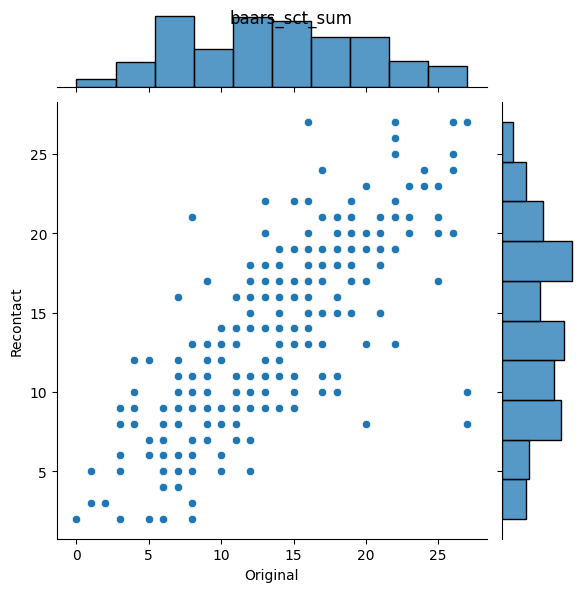

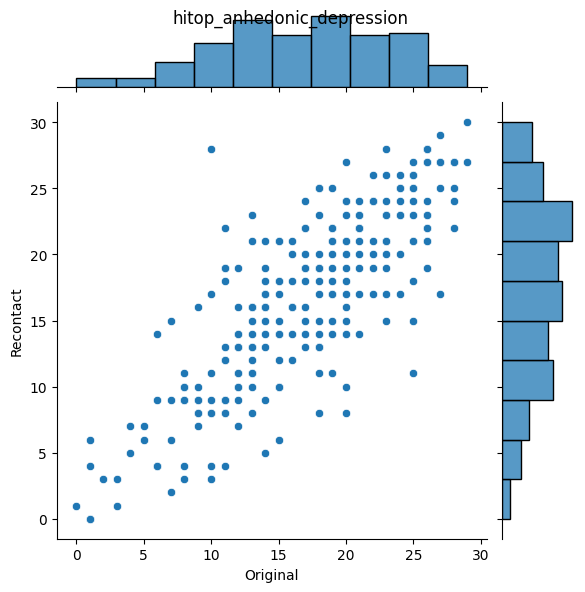

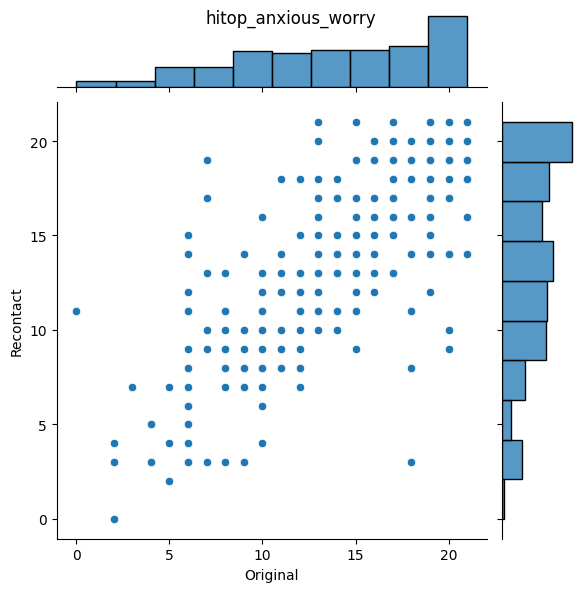

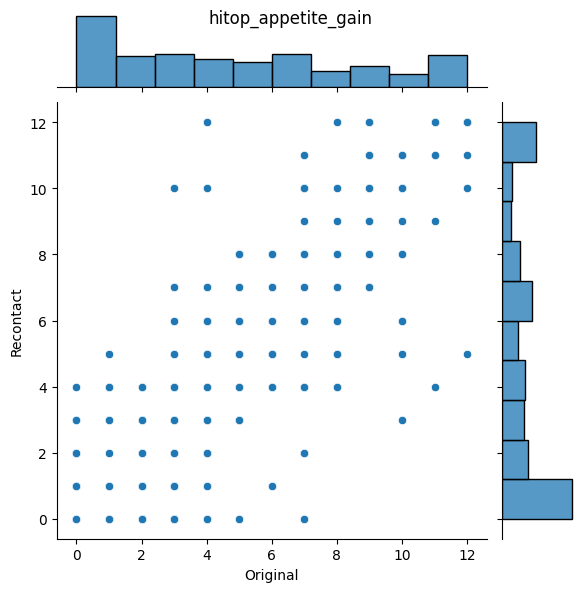

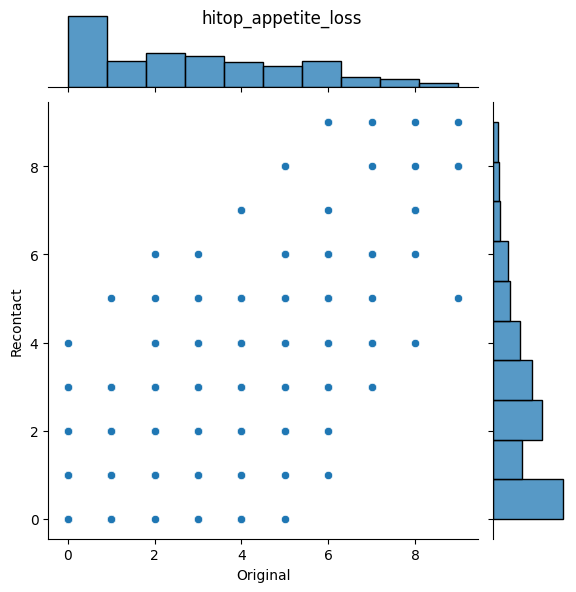

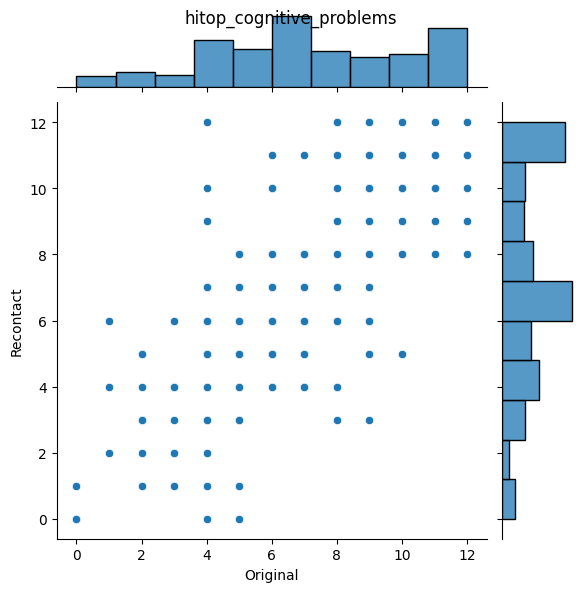

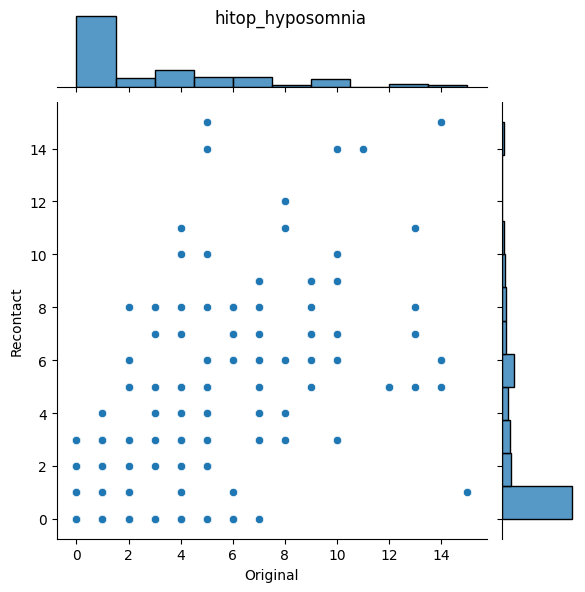

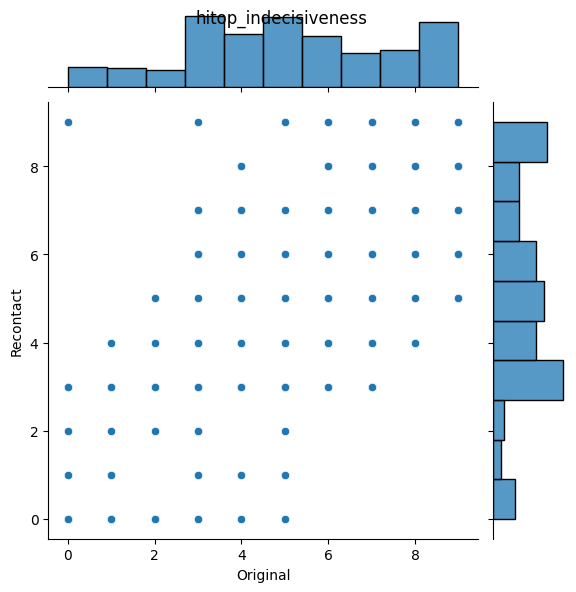

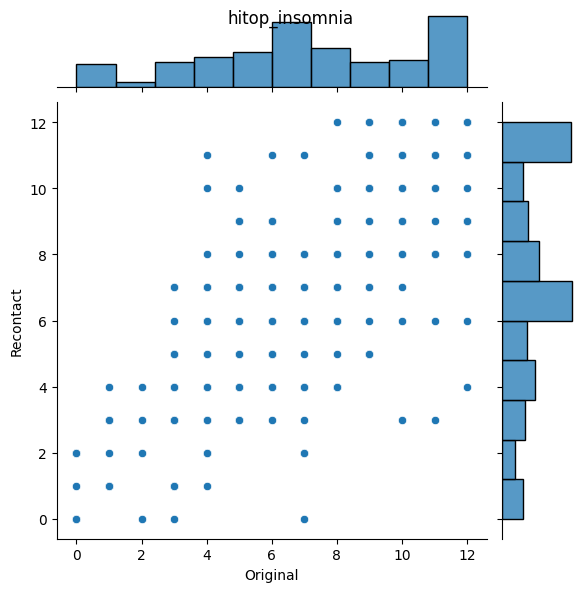

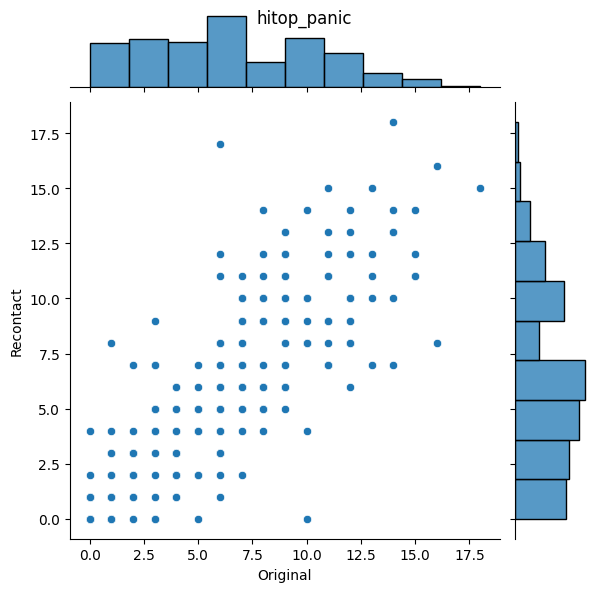

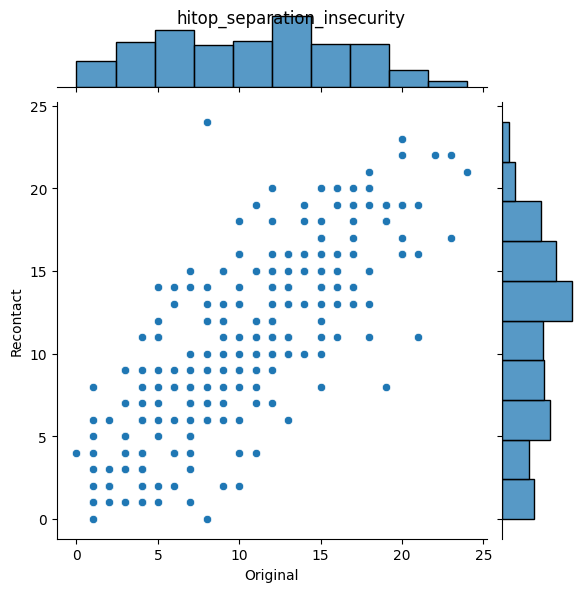

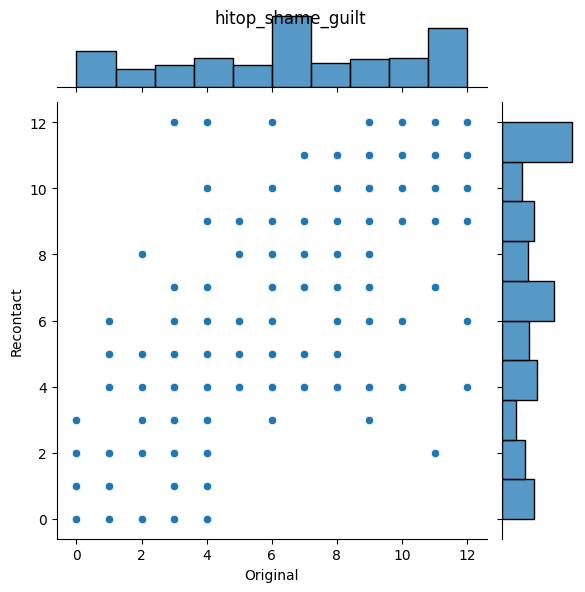

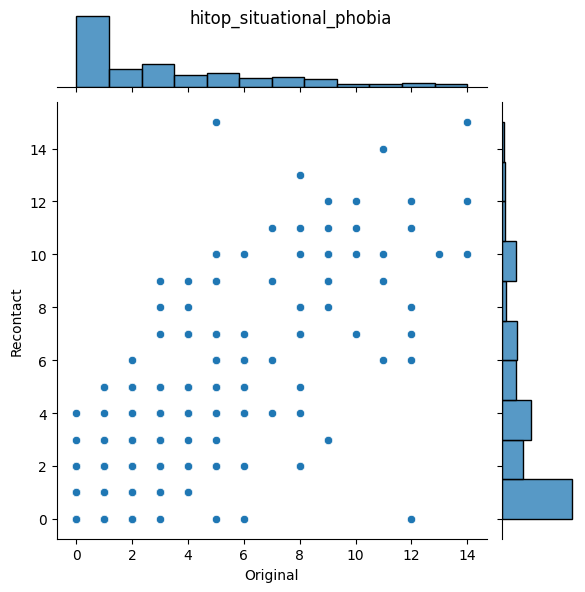

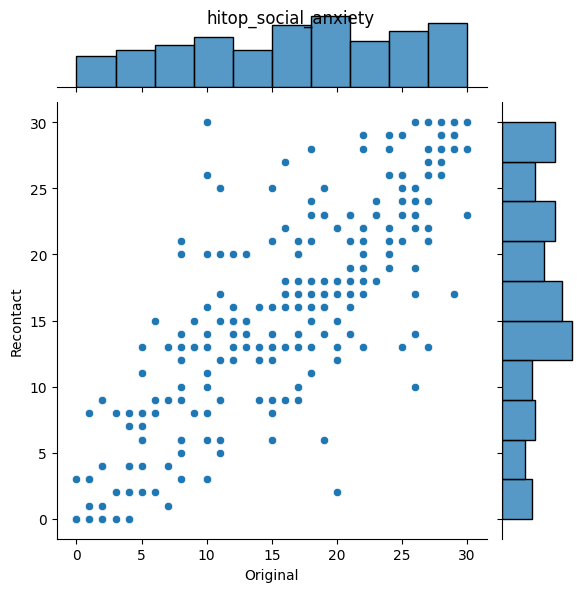

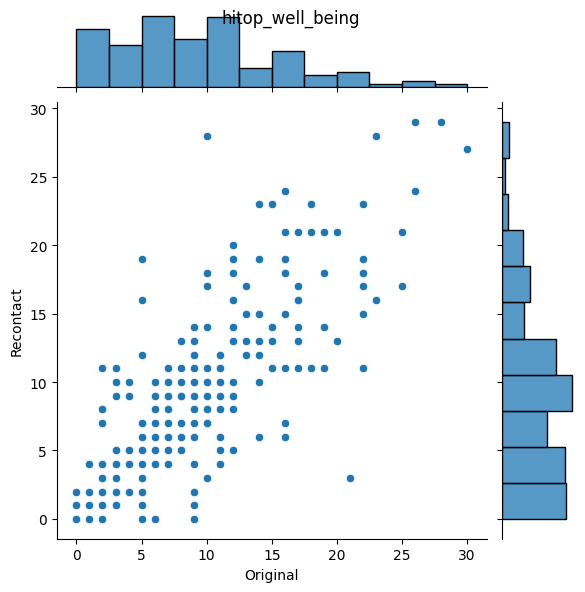

In [112]:
for measure in mydata.columns[1::2]:
    if 'bothered' not in measure:
        do_icc(mydata, measure)

In [113]:
measures = mydata.columns[1::2]
results_table = create_table(mydata, measures)
results_table

hitop_sum
hitop_sum
baars_sum
baars_sum


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


phq_sum
phq_sum
gad_sum
gad_sum


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


baars_inattention_sum
baars_inattention_sum
baars_hyperactivity_sum
baars_hyperactivity_sum


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


baars_impulsivity_sum
baars_impulsivity_sum
baars_sct_sum
baars_sct_sum


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_anhedonic_depression
hitop_anhedonic_depression
hitop_anxious_worry
hitop_anxious_worry


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_appetite_gain
hitop_appetite_gain
hitop_appetite_loss
hitop_appetite_loss


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_cognitive_problems
hitop_cognitive_problems
hitop_hyposomnia
hitop_hyposomnia


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

hitop_indecisiveness
hitop_indecisiveness
hitop_insomnia
hitop_insomnia


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_panic
hitop_panic
hitop_separation_insecurity
hitop_separation_insecurity


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_shame_guilt
hitop_shame_guilt
hitop_situational_phobia
hitop_situational_phobia


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


hitop_social_anxiety
hitop_social_anxiety
hitop_well_being
hitop_well_being


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_64096/1934004992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_icc_row['Measure'] = measure


,Type,Description,ICC,F,df1,df2,pval,CI95%,Measure
1,ICC2,Single random raters,0.823,10.313,256,256,0.0,"[0.78, 0.86]",hitop_sum
1,ICC2,Single random raters,0.803,9.156,256,256,0.0,"[0.76, 0.84]",baars_sum
1,ICC2,Single random raters,0.818,10.051,256,256,0.0,"[0.77, 0.85]",phq_sum
1,ICC2,Single random raters,0.744,6.781,256,256,0.0,"[0.68, 0.79]",gad_sum
1,ICC2,Single random raters,0.805,9.224,256,256,0.0,"[0.76, 0.84]",baars_inattention_sum
1,ICC2,Single random raters,0.712,5.950,256,256,0.0,"[0.65, 0.77]",baars_hyperactivity_sum
1,ICC2,Single random raters,0.811,9.579,256,256,0.0,"[0.77, 0.85]",baars_impulsivity_sum
1,ICC2,Single random raters,0.780,8.053,256,256,0.0,"[0.73, 0.82]",baars_sct_sum
1,ICC2,Single random raters,0.810,9.518,256,256,0.0,"[0.76, 0.85]",hitop_anhedonic_depression
1,ICC2,Single random raters,0.773,7.807,256,256,0.0,"[0.72, 0.82]",hitop_anxious_worry


In [114]:
# put measure first
# shift column 'Name' to first position 
first_column = results_table.pop('Measure') 
  
# insert column using insert(position,column_name, 
# first_column) function 
results_table.insert(0, 'Measure', first_column)

results_table

,Measure,Type,Description,ICC,F,df1,df2,pval,CI95%
1,hitop_sum,ICC2,Single random raters,0.823,10.313,256,256,0.0,"[0.78, 0.86]"
1,baars_sum,ICC2,Single random raters,0.803,9.156,256,256,0.0,"[0.76, 0.84]"
1,phq_sum,ICC2,Single random raters,0.818,10.051,256,256,0.0,"[0.77, 0.85]"
1,gad_sum,ICC2,Single random raters,0.744,6.781,256,256,0.0,"[0.68, 0.79]"
1,baars_inattention_sum,ICC2,Single random raters,0.805,9.224,256,256,0.0,"[0.76, 0.84]"
1,baars_hyperactivity_sum,ICC2,Single random raters,0.712,5.950,256,256,0.0,"[0.65, 0.77]"
1,baars_impulsivity_sum,ICC2,Single random raters,0.811,9.579,256,256,0.0,"[0.77, 0.85]"
1,baars_sct_sum,ICC2,Single random raters,0.780,8.053,256,256,0.0,"[0.73, 0.82]"
1,hitop_anhedonic_depression,ICC2,Single random raters,0.810,9.518,256,256,0.0,"[0.76, 0.85]"
1,hitop_anxious_worry,ICC2,Single random raters,0.773,7.807,256,256,0.0,"[0.72, 0.82]"


In [115]:
results_table.to_csv(path_to_save, index=False)

# Calculate Chrohnbach's alpha

Chronbach’s Alpha is a way to measure the internal consistency of a questionnaire or survey.

The calculations for Cronbach's alpha involve taking the average covariance and dividing it by the average total variance. Therefore, a high alpha value requires the covariance to be high relative to the item variance. In other words, the relationships between the questions account for most of the overall variability.

In [3]:
pg.cronbach_alpha(data=mydata)

(0.7372210116803066, array([0.689, 0.781]))